# Ice Skating Experience in Philippines

For this notebook, the review data that was scraped from several ice skating branches in the Philippines specifically from Google Maps will be used to perform exploratory data analysis (EDA) and sentiment analysis. Here is the main question that we aim to answer given the data:

**Do I expect a good time ice skating here?**

However, the questions are not limited from those. Also, finer details regarding the data will also be investigated along the way.

## Setup/Dependencies

In [1]:
import os
import pandas as pd
import numpy as np
import textwrap
import warnings
import emoji
import re

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from deep_translator import GoogleTranslator

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

pd.set_option('max_colwidth', None)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
nltk.download('all') # download nltk corpus (first time only)

In [149]:
MAIN_PATH = os.getcwd()
DATASET_PATH = os.path.join(MAIN_PATH, 'dataset')
CSV_SAVE_PATH = os.path.join(MAIN_PATH, 'results_csv') # Directory to store the saved CSVs (i.e., DataFrame outputs) of the project

os.makedirs(CSV_SAVE_PATH, exist_ok=True) # Create CSV_SAVE_PATH directory if it does not exist

In [3]:
# Combine the CSV files from three branches into one DataFrame
data = pd.DataFrame(columns=['review_time_ago', 'review_text', 'review_rating', 'review_year', 'branch'])
dataset_files = os.listdir(DATASET_PATH)

for dataset_file in dataset_files:
    branch = dataset_file.split('_')[-1].split('.')[0]
    filepath = os.path.join(DATASET_PATH, dataset_file)
    df = pd.read_csv(filepath)
    df['branch'] = branch
    data = pd.concat([data, df], axis=0)

## Data Wrangling and EDA

In [4]:
data.sample(10)

,review_time_ago,review_text,review_rating,review_year,branch
1002,10 months ago,NaN,4 stars,2023,moa
580,1 year ago,NaN,4 stars,2023,megamall
256,4 years ago,NaN,5 stars,2020,cebu
925,1 year ago,NaN,5 stars,2023,moa
566,1 month ago,NaN,1 star,2024,megamall
405,3 years ago,NaN,5 stars,2021,moa
121,4 years ago,Very Well maintained international standard ice skating rink.,5 stars,2020,megamall
411,1 year ago,NaN,5 stars,2023,moa
76,4 years ago,I just walked past the place but it pools looked nice,4 stars,2020,cebu
476,1 year ago,NaN,5 stars,2023,moa


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2123 entries, 0 to 1034
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review_time_ago  2123 non-null   object
 1   review_text      703 non-null    object
 2   review_rating    2123 non-null   object
 3   review_year      2123 non-null   object
 4   branch           2123 non-null   object
dtypes: object(5)
memory usage: 99.5+ KB


In [6]:
# Drop "review_time_ago" column because "review_year" is derived from it. Thus, making it redundant.
# Furthurmore, it is easy to utilize the "review_year" for data aggregations
data.drop(['review_time_ago'], axis=1, inplace=True)

In [7]:
data.describe()

,review_text,review_rating,review_year,branch
count,703,2123,2123,2123
unique,676,5,10,3
top,Nice place,5 stars,2023,moa
freq,6,1257,1164,1035


In [8]:
print(f"Unique Review Years: {sorted(data['review_year'].unique())}")
print(f"Unique Branches: {sorted(data['branch'].unique())}")
print(f"Unique Ratings: {sorted(data['review_rating'].unique())}")

Unique Review Years: [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Unique Branches: ['cebu', 'megamall', 'moa']
Unique Ratings: ['1 star', '2 stars', '3 stars', '4 stars', '5 stars']


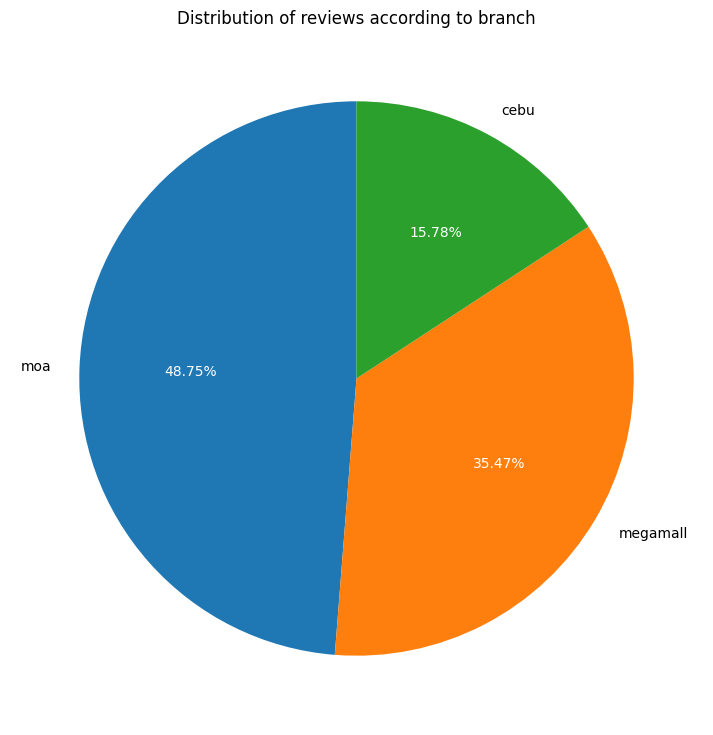

In [220]:
branch_count_df = pd.DataFrame(data['branch'].value_counts())

fig, ax = plt.subplots(figsize=(9, 9))  # Create a figure and axes

# Plot the pie chart
wedges, texts, autotexts = ax.pie(
    branch_count_df['count'], 
    labels=branch_count_df.index, 
    autopct='%1.2f%%', 
    startangle=90
)

ax.set_aspect('equal') # Set aspect ratio to be equal so that pie is drawn as a circle.
ax.set_title('Distribution of reviews according to branch') # Add title to the plot

# Add annotations (percentages) to each wedge
for autotext in autotexts:
    autotext.set_color('white')  # Set text color to white for better visibility

plt.show()

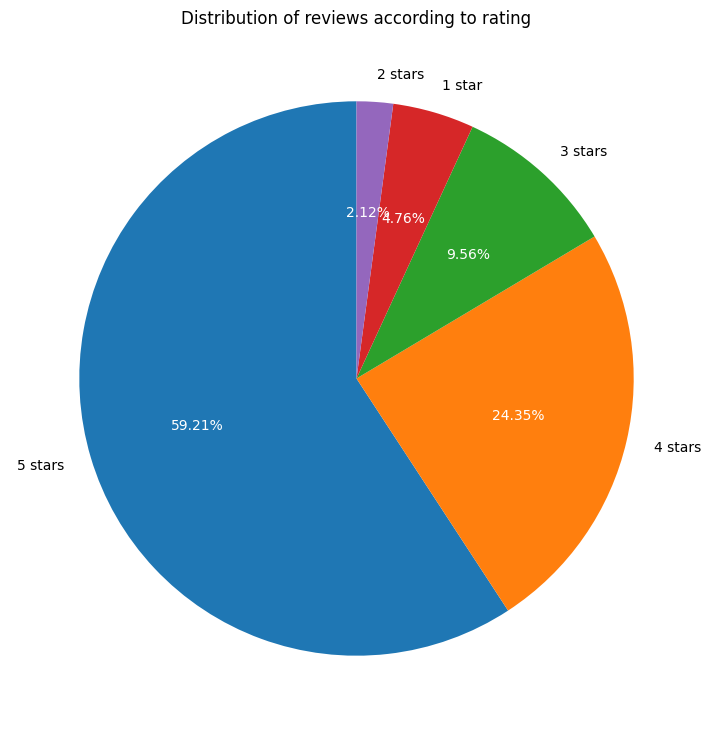

In [10]:
rating_count_df = pd.DataFrame(data['review_rating'].value_counts())

fig, ax = plt.subplots(figsize=(9, 9))  # Create a figure and axes

# Plot the pie chart
wedges, texts, autotexts = ax.pie(
    rating_count_df['count'], 
    labels=rating_count_df.index, 
    autopct='%1.2f%%', 
    startangle=90
)

ax.set_aspect('equal') # Set aspect ratio to be equal so that pie is drawn as a circle.
ax.set_title('Distribution of reviews according to rating') # Add title to the plot

# Add annotations (percentages) to each wedge
for autotext in autotexts:
    autotext.set_color('white')  # Set text color to white for better visibility

plt.show()

* There are 676 unique review texts, 5 unique ratings (1-5 stars), 10 unique years (2015-2024, inclusive), and 3 unique branches (cebu, megamall, and moa).
* There are 703 non-null reviews (i.e., reviews with texts) which means that there are 1420 null reviews which is over 50% of the whole dataset. On the other hand, other three columns are complete.
* From all reviews, the most frequent rating is 5-stars (59.21%). Moreover, the reviews were mostly from moa branch (48.75%) and year 2023.

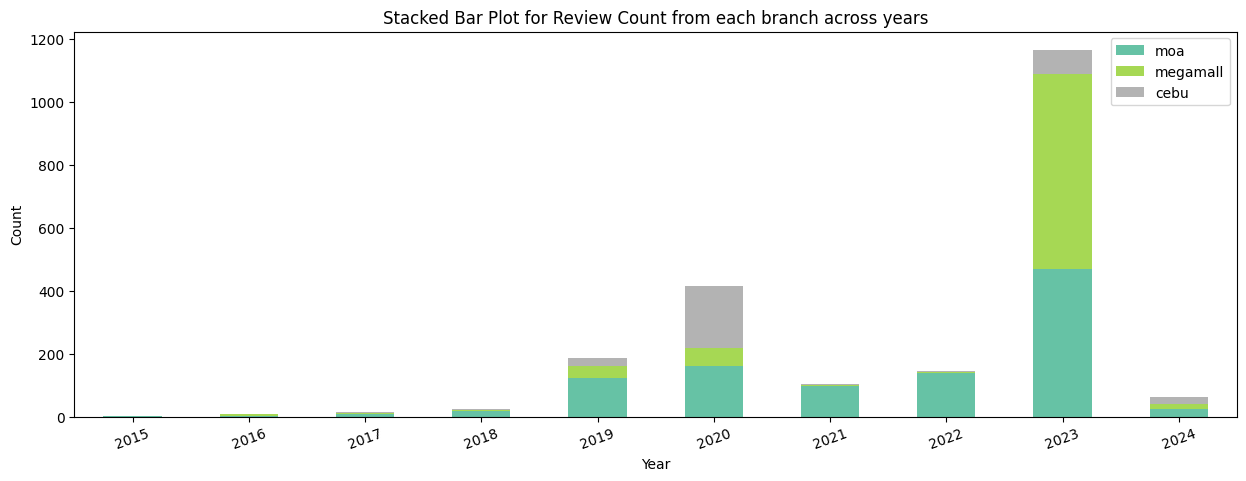

In [246]:
moa, megamall, cebu = [], [], []

for year in sorted(data['review_year'].unique()):
    for branch in ['moa', 'megamall', 'cebu']:
        filt = (data['review_year'] == year) & (data['branch'] == branch)
        if branch == 'moa':
            moa.append(len(data[filt]))
        if branch == 'megamall':
            megamall.append(len(data[filt]))
        if branch == 'cebu':
            cebu.append(len(data[filt]))

year_branch_df = pd.DataFrame({
    'moa' : moa,
    'megamall' : megamall,
    'cebu' : cebu
}, index=sorted(data['review_year'].unique()))

ax = year_branch_df.plot(
    kind='bar',
    stacked=True,
    colormap='Set2',
    figsize=(15, 5),
)

ax.set_title('Stacked Bar Plot for Review Count from each branch across years')
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
plt.show()

* The stacked bar plot above shows the review count across the years with each bar further dissected into the count of each branch for a particular year. Stacked bar plot was used to visually compare the whole and distinct parts of each bar.
* In this case, the year with most reviews was 2023 followed by 2020 and 2019 respectively. On the other hand, 2015 had the lowest amount of reviews followed by 2016 and 2017 respectively.
* The amount of review increased significantly across the years. In year 2023, most reviews were posted on the SM Megamall branch. However, for other years, most reviews were posted on the SM Mall of Asia branch.
* The number of reviews decreased after year 2020 subsequently increasing the year after that. Perhaps, it was caused by the pandemic in the country which started on the same year. With the vaccination roll and more people started going out again, the number of people who ice skated and possibly left reviews increased again.
* Most people visited the moa branch on 2021 and 2022. However, on year 2023, people also started visiting again other branches especially megamall.
* As of the creation of this notebook, it is only the first-half of 2024 making the number of reviews for the aforementioned year understandable.

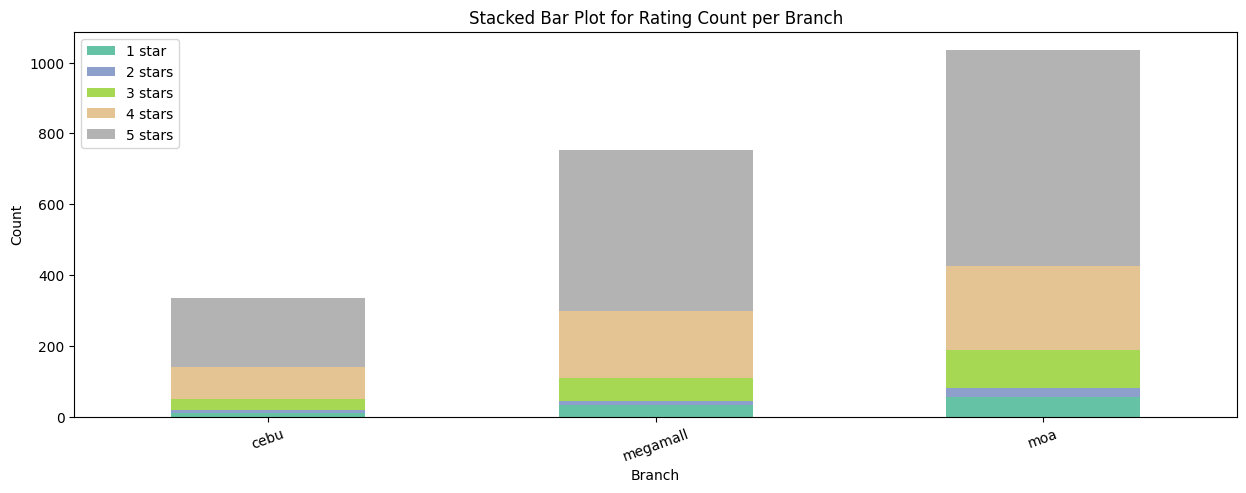

In [245]:
one, two, three, four, five = [], [], [], [], []

for branch in sorted(data['branch'].unique()):
    for rating in sorted(data['review_rating'].unique()):
        filt = (data['branch'] == branch) & (data['review_rating'] == rating)
        if rating == '1 star':
            one.append(len(data[filt]))
        if rating == '2 stars':
            two.append(len(data[filt]))
        if rating == '3 stars':
            three.append(len(data[filt]))
        if rating == '4 stars':
            four.append(len(data[filt]))
        if rating == '5 stars':
            five.append(len(data[filt]))

branch_rating_df = pd.DataFrame({
    '1 star' : one,
    '2 stars' : two,
    '3 stars' : three,
    '4 stars' : four,
    '5 stars' : five
}, index=sorted(data['branch'].unique()))

ax = branch_rating_df.plot(
    kind = 'bar',
    stacked = True,
    figsize = (15, 5),
    colormap = 'Set2'
)

ax.set_title('Stacked Bar Plot for Rating Count per Branch')
ax.set_xlabel('Branch')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
plt.show()

The stacked bar plot shown above indicates that most reviews were posted on the moa branch followed by megamall and cebu respectively. Moreover, the amount of reviews for all branches were 5-star ratings and some are 4-star ratings. There are only few low ratings for all branches.

In [176]:
branch_review_rating_df = pd.DataFrame({
    'branch' : data['branch'],
    'review_rating' : data['review_rating'].str.split(" ").str[0].astype(int)
})

In [184]:
branches = sorted(branch_review_rating_df['branch'].unique())
groups = branch_review_rating_df.groupby('branch')

for branch in branches:
    group = groups.get_group(branch)
    average_rating = group['review_rating'].mean()
    print(f"Average Review Rating for {branch}: {round(average_rating, 3)}")

print("="*50)
average_rating_overall = branch_review_rating_df['review_rating'].mean()
print(f"Average Review Rating Overall: {round(average_rating_overall, 3)}")

Average Review Rating for cebu: 4.343
Average Review Rating for megamall: 4.351
Average Review Rating for moa: 4.272
Average Review Rating Overall: 4.311


* The megamall branch had the highest average review rating of 4.351 with negligible difference from the second branch, cebu. Also, moa had the lowest average review rating but also not that far from the others.
* The rating is quite high given that the highest possible rating is 5.0

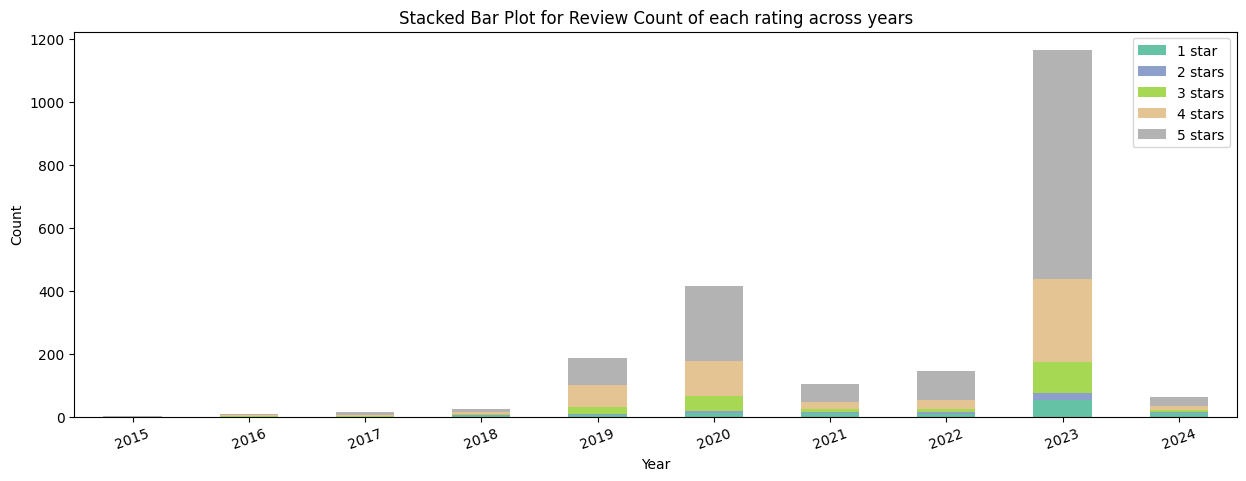

In [247]:
one, two, three, four, five = [], [], [], [], []

for year in sorted(data['review_year'].unique()):
    for rating in sorted(data['review_rating'].unique()):
        filt = (data['review_year'] == year) & (data['review_rating'] == rating)
        if rating == '1 star':
            one.append(len(data[filt]))
        if rating == '2 stars':
            two.append(len(data[filt]))
        if rating == '3 stars':
            three.append(len(data[filt]))
        if rating == '4 stars':
            four.append(len(data[filt]))
        if rating == '5 stars':
            five.append(len(data[filt]))

year_rating_df = pd.DataFrame({
    '1 star' : one,
    '2 stars' : two,
    '3 stars' : three,
    '4 stars' : four,
    '5 stars' : five
}, index=sorted(data['review_year'].unique()))

ax = year_rating_df.plot(
    kind='bar',
    stacked=True,
    figsize=(15, 5),
    colormap='Set2'
)

ax.set_title('Stacked Bar Plot for Review Count of each rating across years')
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)
plt.show()

* Similarly, most the ratings across all years were 5-stars, some were 4-stars, and a few are low ratings (i.e., 1-star to 3-stars).
* Almost or more than half of the ratings from years 2020, 2022, and 2023 were 5-star.
* As of the creation date of the dataset and this notebook, the proportion of the 5-star reviews compared to others in year 2024 decreased where half or more than half of the ratings were 1-star to 4-stars.

In [152]:
data.reset_index(inplace=True, drop=True)
data.to_csv(os.path.join(CSV_SAVE_PATH, 'data.csv'), index=False)

## Sentiment Analysis

* Preprocessing
* Sentiment Intensity Analysis with NLTK VADER
* Results - NLTK VADER
* Sentiment Intensity Analysis with RoBERTa Model
* Results - RoBERTa Model
* Notes and Miscellaneous
* Conclusion and Recommendation

REMOVE Stopwords reference: https://medium.com/@gelsonm/to-use-or-lose-stop-words-in-nlp-de946edaa468
If stopwords are to be removed, maybe make a customized list?
Maybe also do some text clustering (or save this for the next project? maybe do this as another project with another dataset :/)

### Preprocessing

In [14]:
print(f"Number of reviews with no texts: {data['review_text'].isna().sum()}")
review_texts = data['review_text'].dropna()
print(f"Number of reviews with no texts after removal of reviews with no texts: {len(review_texts)}")

Number of reviews with no texts: 1420
Number of reviews with no texts after removal of reviews with no texts: 703


In [15]:
# This cell provides functions for lemmatization with POS tag

lemmatizer = WordNetLemmatizer() # Lemmatizer from NLTK

"""
Function that accepts a string POS tag mapping it to an acceptable format. These are the following parts-of-speech (POS):
1. Adjective
2. Verb
3. Noun
4. Adverb

The lemmatizer only accepts these four POS. For more types, explore this: https://cs.nyu.edu/~grishman/jet/guide/PennPOS.html
"""
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

"""
With a list of tuples with each token and corresponding POS tag as the input,
this function applies the actual mapping of the POS tag to an acceptable format using the get_wordnet_pos() function.
It returns a dictionary with the keys as the words and corresponding values as the acceptable POS tag format.
"""

def remap_pos(text_pos_list_of_tuples):
    token_pos_dict = {}

    for word_pos in text_pos_list_of_tuples:
        wordnet_pos =  get_wordnet_pos(word_pos[1])
        token_pos_dict[word_pos[0]] = wordnet_pos
    
    return token_pos_dict

"""
This function accepts an output from remap_pos().
Each word (key) is lemmatized based on the corresponding POS tag (value).
If the POS tag is not present, return the word itself.
This function returns a string with all or some words lemmatized.
"""
def pos_based_lemmatization(token_pos_dict):
    lemmatized_tokens = []
    for word, wordnet_pos in token_pos_dict.items():
        if wordnet_pos == None:
            lemmatized_tokens.append(word)
        else:
            lemmatized_token = lemmatizer.lemmatize(word=word, pos=wordnet_pos)
            lemmatized_tokens.append(lemmatized_token)
    
    return ' '.join(lemmatized_tokens)

In [16]:
translator = GoogleTranslator(source='tl', target='en') # Tagalog to English Translator

"""
Function that accepts raw review text and outputs the preprocessed review text.
It performs the following processes to each text:
1. Removal of Emoji
    - Although emoji or emoticons convey emotions. I decided to remove them to consider only the text and standardize the steps.
2. Removal of Punctuation Marks
    - Although punctuation marks such as "!" convey intense emotion, I decided to remove them all throughout because their
        presence did not provide significant difference.
3. Removal of New Lines
    - Removal of "\n" present in each review text
4. Removal of Unnecessary Duplicate Characters
    - Specifically for words such as "haaaappyyyy", "soooo", "baaaad", and "loveee" to standardize the words during tokenization and lemmatization
5. English Translation
    - Although majority of the reviews are in english, some reviews contains tagalog words.
    Thus, each review text needed to be translated to english.
6. Lower Casing
    - To standardize the words during tokenization and lemmatization even though review texts with words in upper case might convey
    intense emotion. Fortunately, there were very few words in upper case from all review texts.
7. Tokenization and Lemmatization
    - Tokenization separates each word as a single element (i.e., token) from a review text making a list of tokens. Each token are then
    lemmatized. Lemmatization is the act of breaking down a word to its root.
    - For instance, change, changing, changes, changed, and changer becomes change.
"""
def preprocess_text(review_text):

    if type(review_text) == float: # Skip if there are no text in a review
        return ""
    
    no_emoji = emoji.replace_emoji(str(review_text), replace='') # 1. Removal of Emoji
    no_punctuation_marks = str(re.sub(r'[^\w\s]', '', no_emoji)) # 2. Removal of Punctuation Marks
    no_newline = str(re.sub(r'\n', ' ', no_punctuation_marks)) # 3. Removal of New Lines
    removed_duplicate_characters = re.sub("(.)\\1{2,}", "\\1", no_newline) # 4. Removal of Unnecessary Duplicate Characters
    english_translated = str(translator.translate(removed_duplicate_characters)) # 5. English Translation
    
    # Since all words are getting translated, words that are already in english are also being translated.
    # When "love" or "Love" is translated using GoogleTranslate, it returns "mahal" or "Mahal" which is not english.
    # Thus, return the lemmatized word for "love" if a review with only "love" or "Love" is encountered.
    # Refer to the image below this cell.
    if (removed_duplicate_characters.replace(" ", "") == "Love") and (english_translated.replace(" ", "") == "Mahal"):
        return lemmatizer.lemmatize("love")

    lower = str(english_translated.lower()) # 6. Lower Casing
    
    # 7. Tokenization and Lemmatization
    tokens = word_tokenize(lower) # Tokenize
    text_pos_list_of_tuples = nltk.pos_tag(tokens) # Find the POS tag of each word in the review text
    token_pos_dict = remap_pos(text_pos_list_of_tuples) # Remap the POS tag to an acceptable format
    lemmatized = str(pos_based_lemmatization(token_pos_dict)) # Lemmatize
    
    return lemmatized # Return the lemmatized review text as the preprocessed output

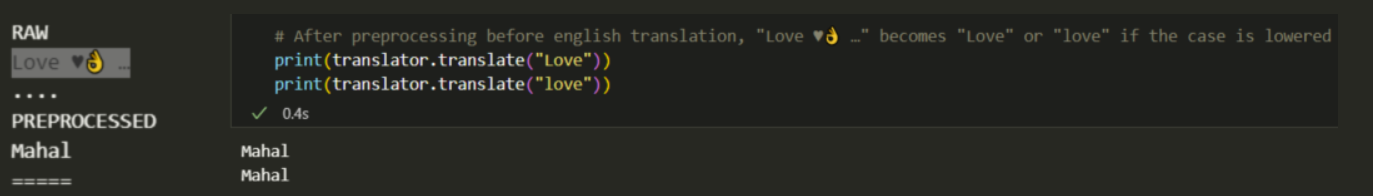

In [155]:
data_preprocessed_filepath = os.path.join(CSV_SAVE_PATH, 'data_preprocessed.csv')
data_filepath = os.path.join(CSV_SAVE_PATH, 'data.csv')

if os.path.exists(data_preprocessed_filepath):
    data_preprocessed = pd.read_csv(data_preprocessed_filepath)
else:
    data = pd.read_csv(data_filepath)
    data_preprocessed = data.copy()
    preprocessed_texts = data_preprocessed['review_text'].apply(preprocess_text)

    data_preprocessed['preprocessed_review_text'] = preprocessed_texts
    data_preprocessed = data_preprocessed[['review_text', 'preprocessed_review_text', 'review_rating', 'review_year', 'branch']]

    data_preprocessed.to_csv(os.path.join(CSV_SAVE_PATH, 'data_preprocessed.csv'), index=False) # Save results as a CSV file

In [166]:
print(f"Number of reviews with no texts after removal of reviews with no texts: {len(review_texts)}")
print(f"Number of reviews with no texts after preprocessing: {len(data_preprocessed.dropna())}")

data_preprocessed.dropna(inplace=True) # Removing reviews with no texts
data_preprocessed.reset_index(inplace=True, drop=True) # Reset index

Number of reviews with no texts after removal of reviews with no texts: 703
Number of reviews with no texts after preprocessing: 693


The number of reviews decreased down to 693 as some of the reviews contained only emojis which were removed during preprocessing.

### Sentiment Intensity Analysis with NLTK VADER

In [160]:
analyzer = SentimentIntensityAnalyzer() # NLTK VADER Sentiment Intensity Analyzer

def get_sentiment(review_text):

    if review_text == "": # Skip if there are no text in a review
        return None
    
    scores = analyzer.polarity_scores(review_text) # Get and return polarity scores
    return scores

In [167]:
data_vader_filepath = os.path.join(CSV_SAVE_PATH, 'data_vader.csv')
data_preprocessed_filepath = os.path.join(CSV_SAVE_PATH, 'data_preprocessed.csv')

if os.path.exists(data_vader_filepath):
    data_vader = pd.read_csv(data_vader_filepath)
else:
    data_preprocessed = pd.read_csv(data_preprocessed_filepath)
    data_preprocessed.dropna(inplace=True)
    data_preprocessed.reset_index(inplace=True, drop=True)
    data_vader = data_preprocessed.copy()
    data_vader['scores'] = data_vader['preprocessed_review_text'].apply(get_sentiment) # Get scores
    data_vader['compound_score'] = data_vader['scores'].apply(lambda x: None if x == None else x['compound']) # Get compound scores

    """
    The score has three scores: pos, neu, neg, and compound.
    The compound score is a unidimensional measure of sentiment intensity for a given sentence.
    Let's say the sentiment intensity can either be explained by pos, neu, and neg scores or only the compound score.
    Thus, we can say that compound score can be a single metric for determining the sentiment intensity analysis.

    The compound score has a range of (-1.0, 1.0) with values more on the negative side having a negative sentiment and positive on the other side.
    By default, the thresholding in the neutral spectrum or range is ±0.05 but I adjusted it to ±0.10.

    For more information: https://github.com/cjhutto/vaderSentiment
    """
    data_vader['sentiment_int'] = data_vader['scores'].apply(lambda x: None if x == None 
    else('positive' if x['compound'] > 0.10 
    else ('neutral' if (x['compound'] <= 0.10 and x['compound'] >= -0.10) else 'negative')))

    data_vader.to_csv(data_vader_filepath, index=False) # Save results

### Results - NLTK VADER

In [168]:
data_vader

,review_text,preprocessed_review_text,review_rating,review_year,branch,scores,compound_score,sentiment_int
0,"They have time slots to choose from. Food stalls nearby. There was a waiver form you need to fill which the cashier forgot to tell us that we eventually found out when we were about to get our skating shoes. It was a bit chaotic when we were inside to get our skating shoes. There was no proper line and some would just cut in line probably because they are excited to get to the rink. There are also extra fees for the bear, locker and socks. The socks cost about 50 pesos and they say its important to buy if the socks you're wearing does not cover until your calves because people could get rash due to many people using the shoes. Helmets are not sturdy and smelly due to sweat from previous user. But I'm in for the experience so I just shrug off my whole chaotic encounter. There were figure skaters practicing and playing around at the rink too so it was entertaining to watch.",they have time slot to choose from food stall nearby there be a waiver form you need fill which the cashier forget tell us that we eventually find out when be about get our skate shoe it bit chaotic inside no proper line and some would just cut in probably because be excite rink also extra fee for bear locker sock cost 50 peso say its important buy if youre wear do not cover until your calf people could rash due many use helmet sturdy smelly sweat previous user but im experience so i shrug off my whole encounter figure skater practice play around at too entertain watch,4 stars,2024,cebu,"{'neg': 0.086, 'neu': 0.832, 'pos': 0.082, 'compound': 0.3716}",0.3716,positive
1,"Was looking through old photos and came across photos from when I skated mid December and got reminded about how bad my skating experience was… first, while lining up, I witnessed the guard very rudely speak to multiple of the other customers and treat them with no respect. Very unprofessional needs more training, perhaps even switch out for a different guard. I also asked him twice if we could go in yet, and both times he ignored me. Upon entering the skates were not only stinky but one of the skates my friend received had broken laces? I don’t know how that was allowed. The ice was honestly really dangerous too. It was very bumpy and had a lot of holes that you could very easily trip on. Crowd control was not that great either, everyone was everywhere made it even more dangerous to skate. Overall it was okay, but would’ve been more stressing if my friends weren’t distracting me from the chaos.",be look through old photo and come across from when i skate mid december get remind about how bad my skate experience first while line up witness the guard very rudely speak to multiple of other customer treat them with no respect unprofessional need more training perhaps even switch out for a different also ask him twice if we could go in yet both time he ignore me upon enter skate be not only stinky but one friend receive have break lace dont know that allow ice honestly really dangerous too it bumpy lot hole you easily trip on crowd control great either everyone everywhere make skate overall okay would have be stressful friend n't distract chaos,2 stars,2024,cebu,"{'neg': 0.138, 'neu': 0.629, 'pos': 0.233, 'compound': 0.9473}",0.9473,positive
2,"it was fun and enjoyable went here with the love of my life heeheh naa pd mga instructor and skating students it was too nice to see. One thing I despise kay they gave me a really worn out skating shoes and ohab kaayoo 🥹🥹🥹 I guess I do not have a choice??? Lain sd kaayo mamili ko na mao na may gihatag. Either way, I had fun ans thats what matters",it be fun and enjoyable go here with the love of my life heeheh there be instructor skate student too nice to see one thing i despise kay they give me a really wear out shoe ohab kayoo guess do not have choice lain sd kaao 'll go shop that 's what give either way have an thats matter,3 stars,2024,cebu,"{'n

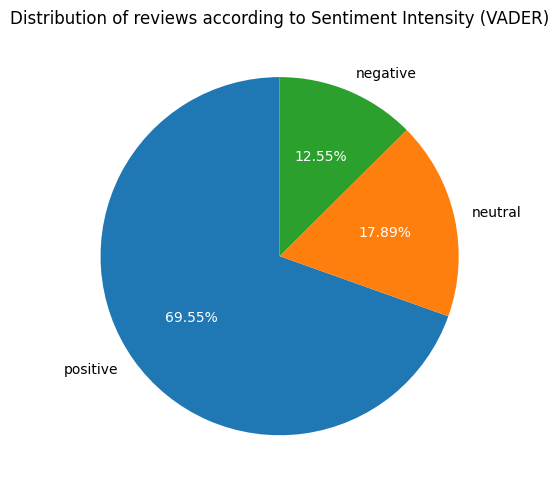

In [169]:
sentimentint_count_df = pd.DataFrame(data_vader['sentiment_int'].value_counts())

fig, ax = plt.subplots(figsize=(5, 5))  # Create a figure and axes

# Plot the pie chart
wedges, texts, autotexts = ax.pie(
    sentimentint_count_df['count'], 
    labels=sentimentint_count_df.index, 
    autopct='%1.2f%%', startangle=90
)

ax.set_aspect('equal') # Set aspect ratio to be equal so that pie is drawn as a circle.
ax.set_title('Distribution of reviews according to Sentiment Intensity (VADER)') # Add title to the plot

# Add annotations (percentages) to each wedge
for autotext in autotexts:
    autotext.set_color('white')  # Set text color to white for better visibility

plt.tight_layout()
plt.show()

As can be seen from the pie chart, most reviews with texts were positive based on the VADER model for Sentiment Intensity Analysis from NLTK which comprises more than half of those reviews.

In [23]:
data_vader['review_rating'] = data_vader['review_rating'].str.split(' ').str[0].astype(int) # Extract only the rating integer

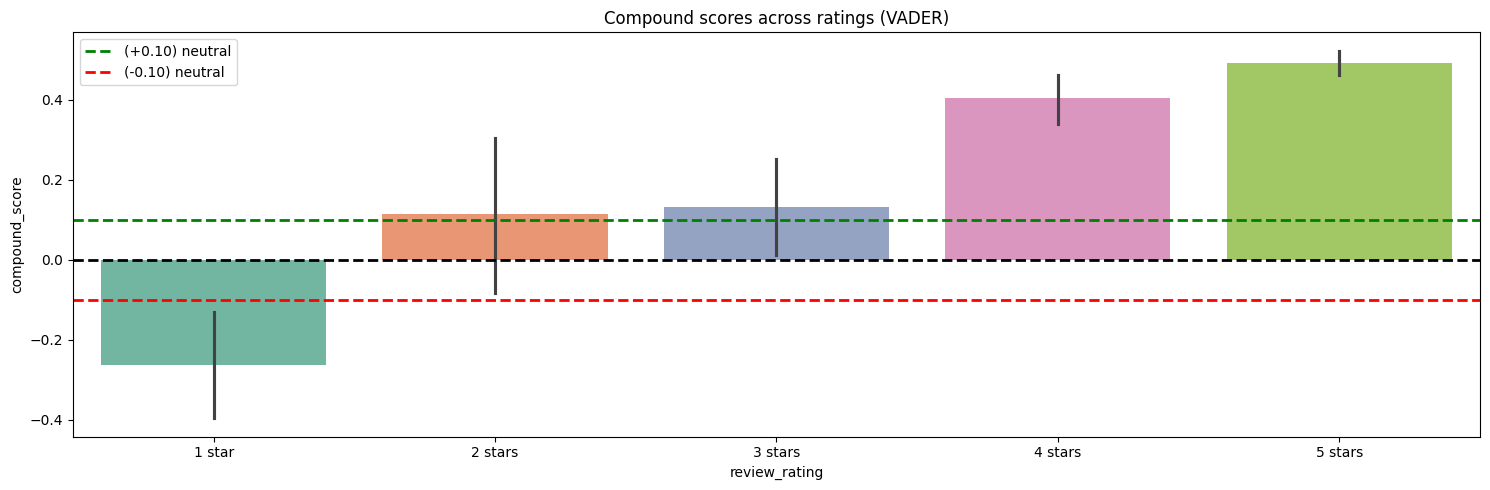

In [260]:
rating_order_asc = sorted(data_vader['review_rating'].unique())

plt.figure(figsize=(15, 5))
sns.barplot(data=data_vader, x='review_rating', y='compound_score', palette='Set2', order=rating_order_asc)
plt.title("Compound scores across ratings (VADER)")


plt.axhline(y=0, color='black', linestyle='--', linewidth=2)
plt.axhline(y=0.10, color='green', linestyle='--', linewidth=2, label='(+0.10) neutral')
plt.axhline(y=-0.10, color='red', linestyle='--', linewidth=2, label='(-0.10) neutral')

plt.legend()
plt.tight_layout()
plt.show()

* As the review rating level increases, the compound score also increases. Based on these observation, majority the review texts matches the corresponding embedded sentiment.
* All of the review texts with 1-star rating have negative compound scores.
* Almost all of the review texts with 2-stars and 3-stars rating have compound scores within the neutral range (i.e., -0.10 to +0.10).
* Some review texts with 4-stars and 5-stars rating have compound scores within the neutral range (i.e., -0.10 to +0.10). However, most of them are above the +0.10 threshold for neutral.

In [252]:
data_vader['pos'] = data_vader['scores'].apply(lambda x: x['pos'])
data_vader['neu'] = data_vader['scores'].apply(lambda x: x['neu'])
data_vader['neg'] = data_vader['scores'].apply(lambda x: x['neg'])

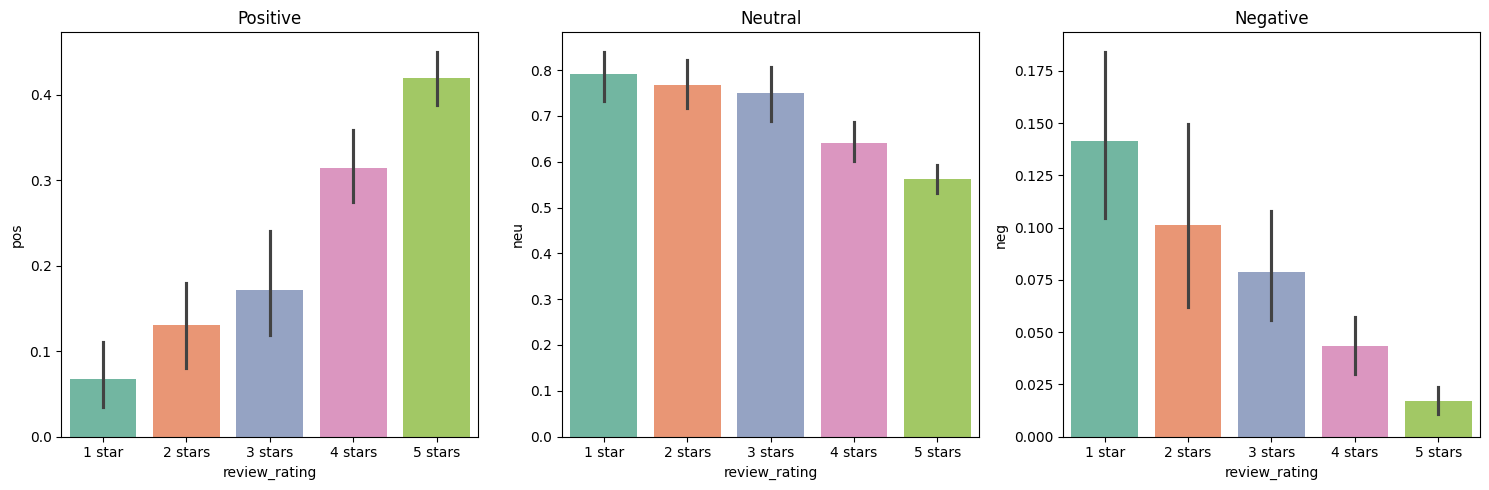

In [254]:
rating_order_asc = sorted(data_vader['review_rating'].unique())

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=data_vader, x='review_rating', y='pos', ax=axs[0], palette='Set2', order=rating_order_asc)
sns.barplot(data=data_vader, x='review_rating', y='neu', ax=axs[1], palette='Set2', order=rating_order_asc)
sns.barplot(data=data_vader, x='review_rating', y='neg', ax=axs[2], palette='Set2', order=rating_order_asc)
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')

plt.tight_layout()
plt.show()

The figure above shows three bar plots of review ratings versus the positive scores, neutral scores, and negative scores respectively.

* As the review rating increases, the positive score of a review also increases.
* As the review rating increases, the neutral score decreases but at a slower degree.
* As the review rating increases, the negative score increases.

The figure implies that same as the previous figure but only aggregated based on the positive, neutral, and negative scores. However, review texts that were tagged as neutral seem to have lower ratings.

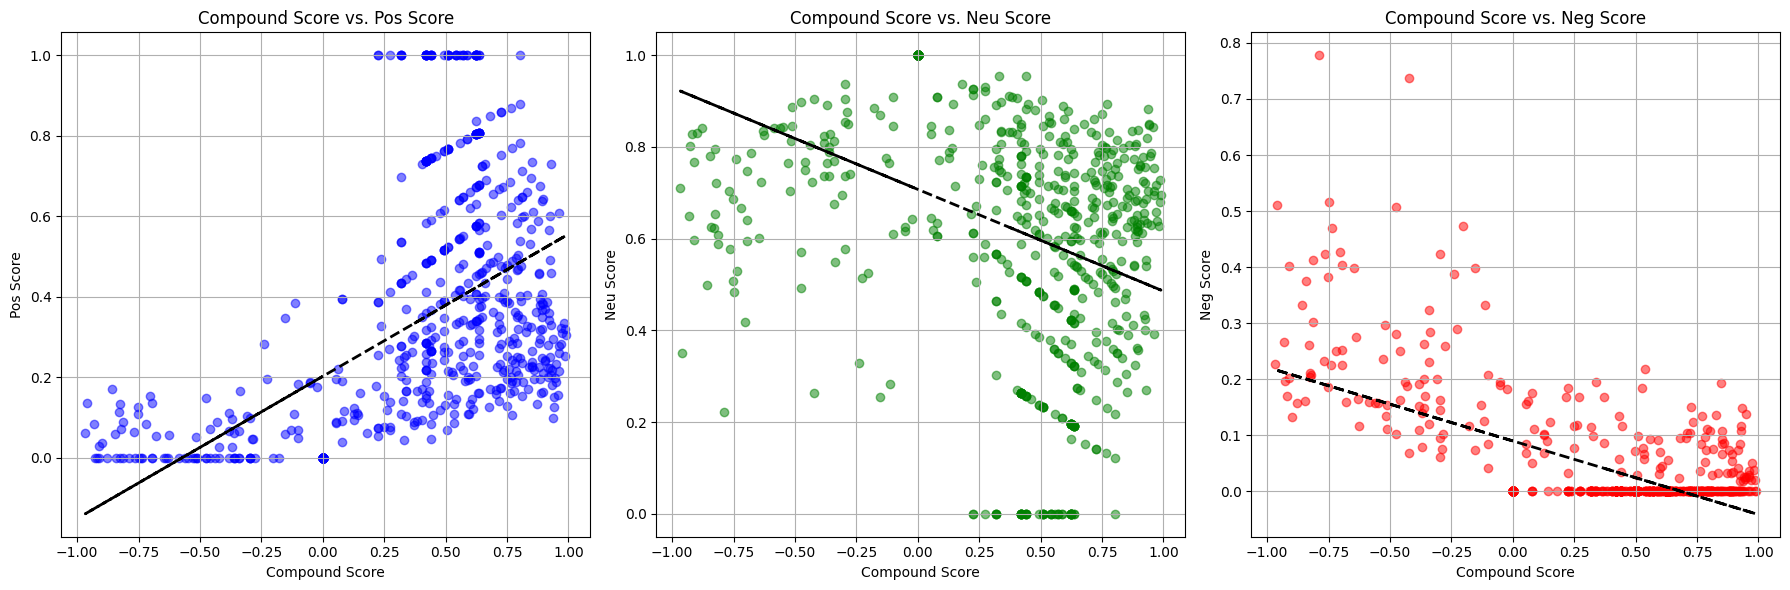

In [27]:
# Create a figure with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figsize as needed

# List of sentiments and corresponding colors
sentiments = ['pos', 'neu', 'neg']
colors = ['blue', 'green', 'red']

# Iterate over sentiments to create scatter plots
for i, sentiment in enumerate(sentiments):
    # Extract x and y data
    x = data_vader['compound_score']
    y = data_vader[sentiment]
    
    # Scatter plot on the current axis
    axes[i].scatter(x, y, color=colors[i], alpha=0.5, marker='o')
    
    # Calculate the coefficients (slope and intercept) of the linear regression
    coefficients = np.polyfit(x, y, 1)
    slope = coefficients[0]
    intercept = coefficients[1]
    
    # Generate the line of best fit using the calculated slope and intercept
    line_of_best_fit = slope * x + intercept
    
    # Plot the line of best fit
    axes[i].plot(x, line_of_best_fit, color='black', linestyle='--', linewidth=2)
    
    # Set labels and title for each subplot
    axes[i].set_xlabel('Compound Score')
    axes[i].set_ylabel(sentiment.capitalize() + ' Score')  # Set y-axis label with sentiment name
    axes[i].set_title('Compound Score vs. ' + sentiment.capitalize() + ' Score')
    
    # Optionally, add grid lines
    axes[i].grid(True)

# Adjust layout and display the figure
plt.tight_layout()  # Adjust subplot layout to prevent overlap
plt.show()

The figure above shows three regression plots for compound scores versus the positive scores, neutral scores, and negative scores respectively. To see the trend of the correlation, a line was fitted.

* The compound scores and positive scores seem to have a positive correlation which is expected. The more positive the sentiment is, the more positive the compound score is. Review texts that have highly positive compound scores have perfect or nearly perfect positive scores. Conversely, review texts with highly negative compound scores have very low positive scores that are close to zero. Also, there seems to be a cluster of review texts in the lower right of the first plot with highly positive compound scores but with low positive scores.

* The compounds scores and neutral scores seem to have a negative correlation which means that some review texts tagged as neutral based on the compound score had lower neutral score. However, the magnitude is still high. Ideally, the dots are clustered in the middle and on the higher end of the y-axis, but review texts with highly positive compound scores seem to have relatively high neutral scores as can be seen on the second plot with the dots highly clustered on the right side. 

* The compound scores and negative scores seem to have a negative correlation with the magnitude being relatively low compared to the neutral scores. As can be observed, most review texts with significantly high compound score are clustered and have low negative scores which is also expected.

The results is not ideal but it is not that bad.

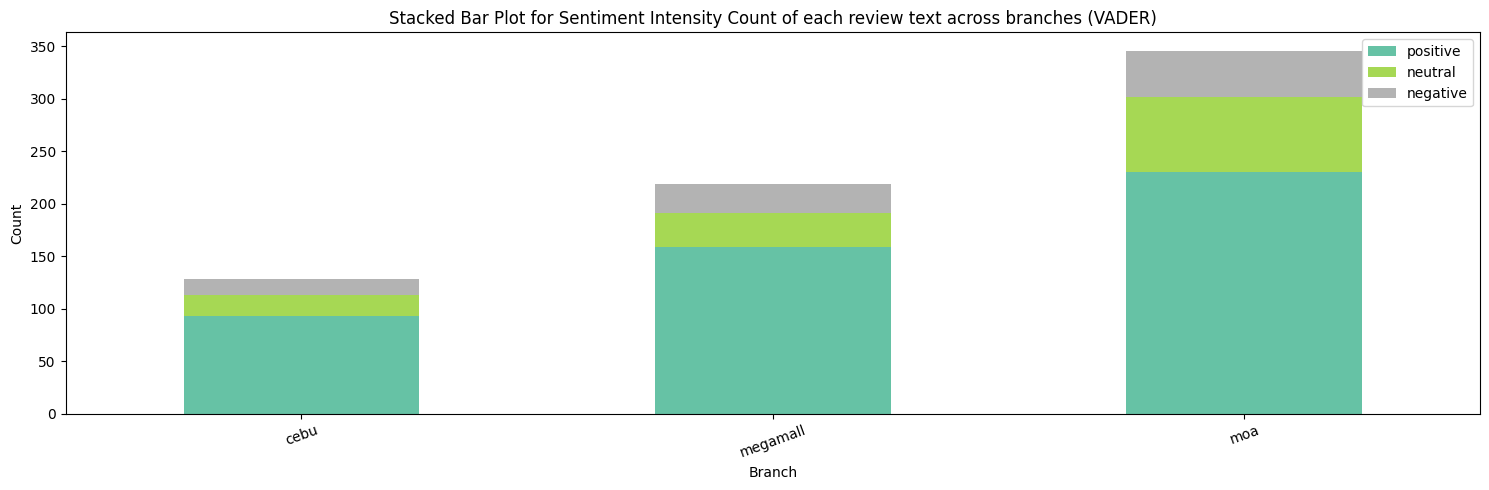

In [261]:
pos, neu, neg = [], [], []

for branch in sorted(data_vader['branch'].unique()):
    for intensity in sorted(data_vader['sentiment_int'].unique()):
        filt = (data_vader['branch'] == branch) & (data_vader['sentiment_int'] == intensity)
        if intensity == 'positive':
            pos.append(len(data_vader[filt]))
        if intensity == 'neutral':
            neu.append(len(data_vader[filt]))
        if intensity == 'negative':
            neg.append(len(data_vader[filt]))

branch_sentimentint_df = pd.DataFrame({
    'positive' : pos,
    'neutral' : neu,
    'negative' : neg
}, index=sorted(data['branch'].unique()))

ax = branch_sentimentint_df.plot(
    kind='bar',
    stacked=True,
    figsize=(15, 5),
    colormap='Set2'
)

ax.set_title('Stacked Bar Plot for Sentiment Intensity Count of each review text across branches (VADER)')
ax.set_xlabel('Branch')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

plt.tight_layout()
plt.show()

* For reviews with text, the moa branch still had the highest count.
* For all branches, majority of the review texts are positive while negative had the least count which can be observed visually from the figure above.

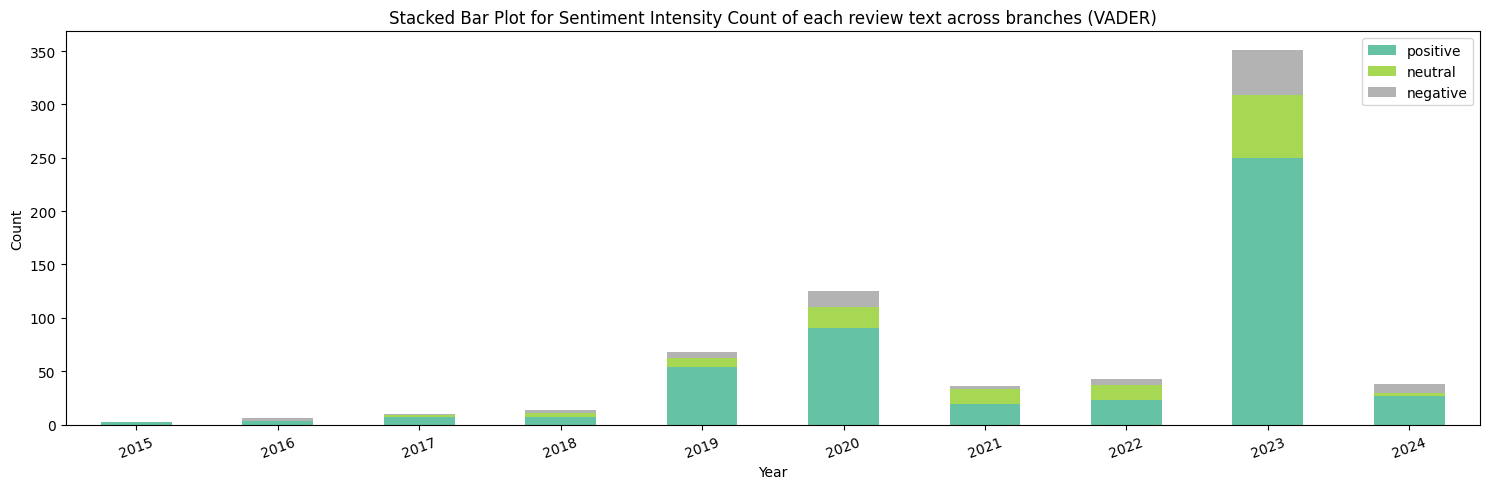

In [262]:
pos, neu, neg = [], [], []

for year in sorted(data_vader['review_year'].unique()):
    for intensity in sorted(data_vader['sentiment_int'].unique()):
        filt = (data_vader['review_year'] == year) & (data_vader['sentiment_int'] == intensity)
        if intensity == 'positive':
            pos.append(len(data_vader[filt]))
        if intensity == 'neutral':
            neu.append(len(data_vader[filt]))
        if intensity == 'negative':
            neg.append(len(data_vader[filt]))

branch_sentimentint_df = pd.DataFrame({
    'positive' : pos,
    'neutral' : neu,
    'negative' : neg
}, index=sorted(data['review_year'].unique()))

ax = branch_sentimentint_df.plot(
    kind='bar',
    stacked=True,
    figsize=(15, 5),
    colormap='Set2'
)

ax.set_title('Stacked Bar Plot for Sentiment Intensity Count of each review text across branches (VADER)')
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

plt.tight_layout()
plt.show()

* Similarly for most of the years, most of the reviews were tagged as positive.
* However, there seems to be a significant amount of reviews tagged as negative on year 2024.

### Sentiment Intensity Analysis with RoBERTa Model

In [32]:
"""
This is a deep-learning based approach for Sentiment Intensity Analysis.
The model that will be used will be a pre-trained transformer model from Hugging Face.

A Transformer is a state-of-the-art deep learning model architecture capable of
effectively capturing contextual information such as text data through means of attention mechanism.
Basically, in the context of text data, it understands the meaning of the words based on surrounding words
and not only by the words themselves.

Research Paper for Transformers: https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf

Hugging Face Model: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment
This model was trained on ~58M tweets and was finetuned for sentiment analysis.
It provides scores for the following respectively: negative, neutral, and positive.
"""

MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL) # Tokenizer
model = AutoModelForSequenceClassification.from_pretrained(MODEL) # Model

In [50]:
"""
Function that provides the sentiment scores of a given review_text string.
The output is a dictionary containing the keys: neg, neu, and pos with correspdonding scores as values.
"""
def get_sentiment_scores_roberta(review_text):
    if type(review_text) == float:
        return None
    
    encoded_text = tokenizer(review_text, return_tensors='pt') # Tokenize
    output = model(**encoded_text) # Inference
    scores = output[0][0].detach().numpy() # Extract scores
    scores_softmax = softmax(scores) # Apply softmax to normalize

    # Create results payload dictionary
    scores_dict = {
        'neg' : scores_softmax[0],
        'neu' : scores_softmax[1],
        'pos' : scores_softmax[2]
    }

    return scores_dict

In [170]:
data_roberta_filepath = os.path.join(CSV_SAVE_PATH, 'data_roberta.csv')
data_preprocessed_filepath = os.path.join(CSV_SAVE_PATH, 'data_preprocessed.csv')

if os.path.exists(data_roberta_filepath):
    data_roberta = pd.read_csv(data_roberta_filepath)
else:
    data_preprocessed = pd.read_csv(data_preprocessed_filepath)
    data_preprocessed.dropna(inplace=True)
    data_preprocessed.reset_index(inplace=True, drop=True)
    data_roberta = data_preprocessed.copy()

    # Sentiment Intensity Analysis on all preprocessed_review_text
    data_roberta['scores_roberta'] = data_roberta['preprocessed_review_text'].apply(get_sentiment_scores_roberta) 
    # Extraction of neg, neu, and pos scores as new columns
    data_roberta['neg'] = data_roberta['scores_roberta'].apply(lambda x: x['neg'])
    data_roberta['neu'] = data_roberta['scores_roberta'].apply(lambda x: x['neu'])
    data_roberta['pos'] = data_roberta['scores_roberta'].apply(lambda x: x['pos'])
    
    # Mapping the softmax scores to sentiment intensity classes
    sentiments_in_order = ['negative', 'neutral', 'positive']
    data_roberta['sentiment_int'] = data_roberta['scores_roberta'].apply(lambda x: sentiments_in_order[np.argmax(np.array(list(x.values())))])

    # Keep records with review_text
    filt = ~data_roberta['scores_roberta'].isna()
    data_roberta = data_roberta[filt]

    data_roberta.to_csv(data_roberta_filepath, index=False) # Save results

### Results - RoBERTa Model

In [143]:
data_roberta

,review_text,preprocessed_review_text,review_rating,review_year,branch,scores_roberta,neg,neu,pos,sentiment_int
0,"They have time slots to choose from. Food stalls nearby. There was a waiver form you need to fill which the cashier forgot to tell us that we eventually found out when we were about to get our skating shoes. It was a bit chaotic when we were inside to get our skating shoes. There was no proper line and some would just cut in line probably because they are excited to get to the rink. There are also extra fees for the bear, locker and socks. The socks cost about 50 pesos and they say its important to buy if the socks you're wearing does not cover until your calves because people could get rash due to many people using the shoes. Helmets are not sturdy and smelly due to sweat from previous user. But I'm in for the experience so I just shrug off my whole chaotic encounter. There were figure skaters practicing and playing around at the rink too so it was entertaining to watch.",they have time slot to choose from food stall nearby there be a waiver form you need fill which the cashier forget tell us that we eventually find out when be about get our skate shoe it bit chaotic inside no proper line and some would just cut in probably because be excite rink also extra fee for bear locker sock cost 50 peso say its important buy if youre wear do not cover until your calf people could rash due many use helmet sturdy smelly sweat previous user but im experience so i shrug off my whole encounter figure skater practice play around at too entertain watch,4 stars,2024,cebu,"{'neg': 0.17287022, 'neu': 0.6904912, 'pos': 0.1366385}",0.172870,0.690491,0.136639,neutral
1,"Was looking through old photos and came across photos from when I skated mid December and got reminded about how bad my skating experience was… first, while lining up, I witnessed the guard very rudely speak to multiple of the other customers and treat them with no respect. Very unprofessional needs more training, perhaps even switch out for a different guard. I also asked him twice if we could go in yet, and both times he ignored me. Upon entering the skates were not only stinky but one of the skates my friend received had broken laces? I don’t know how that was allowed. The ice was honestly really dangerous too. It was very bumpy and had a lot of holes that you could very easily trip on. Crowd control was not that great either, everyone was everywhere made it even more dangerous to skate. Overall it was okay, but would’ve been more stressing if my friends weren’t distracting me from the chaos.",be look through old photo and come across from when i skate mid december get remind about how bad my skate experience first while line up witness the guard very rudely speak to multiple of other customer treat them with no respect unprofessional need more training perhaps even switch out for a different also ask him twice if we could go in yet both time he ignore me upon enter skate be not only stinky but one friend receive have break lace dont know that allow ice honestly really dangerous too it bumpy lot hole you easily trip on crowd control great either everyone everywhere make skate overall okay would have be stressful friend n't distract chaos,2 stars,2024,cebu,"{'neg': 0.7763913, 'neu': 0.197548, 'pos': 0.026060633}",0.776391,0.197548,0.026061,negative
2,"it was fun and enjoyable went here with the love of my life heeheh naa pd mga instructor and skating students it was too nice to see. One thing I despise kay they gave me a really worn out skating shoes and ohab kaayoo 🥹🥹🥹 I guess I do not have a choice??? Lain sd kaayo mamili ko na mao na may gihatag. Either way, I had fun ans thats what matters",it be fun and enjoyable go here with the love of my life heeheh there be instructor skate student too nice to see one thing i despise kay they give me a really wear out shoe ohab kayoo guess do not have choice lain sd kaao 'll go shop that 's what give either way have an thats

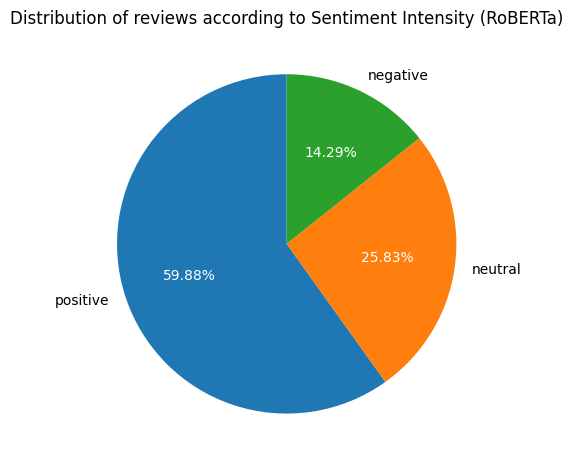

In [127]:
sentimentint_roberta_count_df = pd.DataFrame(data_roberta['sentiment_int'].value_counts())

fig, ax = plt.subplots(figsize=(5, 5))  # Create a figure and axes

# Plot the pie chart
wedges, texts, autotexts = ax.pie(
    sentimentint_roberta_count_df['count'], 
    labels=sentimentint_roberta_count_df.index, 
    autopct='%1.2f%%', startangle=90
)

ax.set_aspect('equal') # Set aspect ratio to be equal so that pie is drawn as a circle.
ax.set_title('Distribution of reviews according to Sentiment Intensity (RoBERTa)') # Add title to the plot

# Add annotations (percentages) to each wedge
for autotext in autotexts:
    autotext.set_color('white')  # Set text color to white for better visibility

plt.tight_layout()
plt.show()

Similar to VADER, more than half of the review texts were deemed as positive based on the output of RoBERTa model. Also, negative review texts have the least value counts.

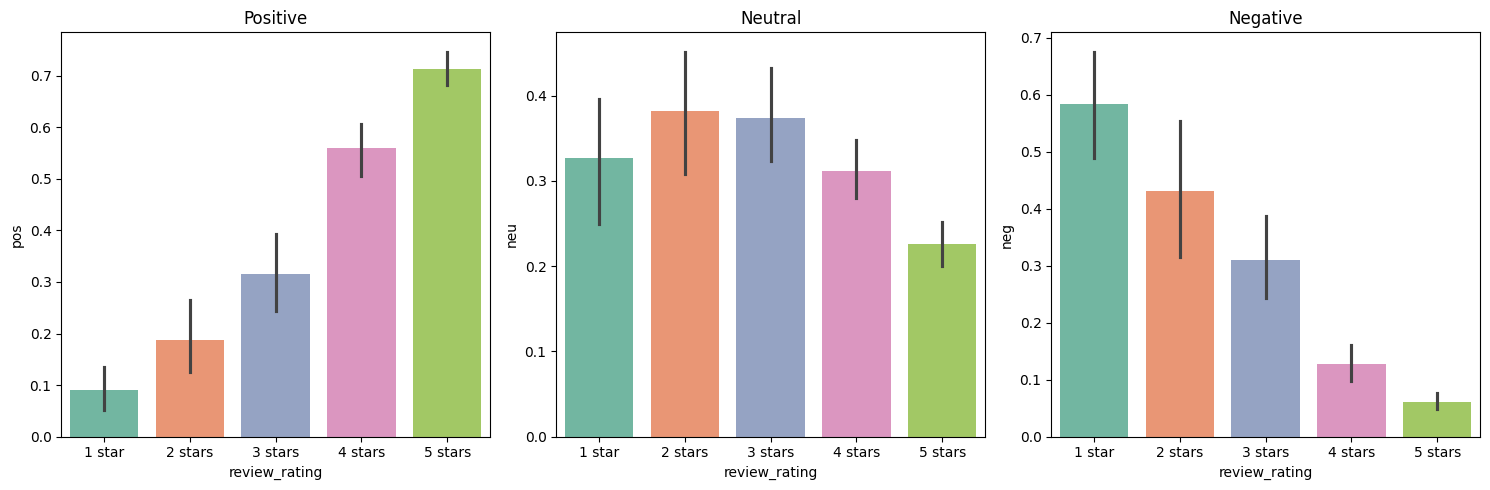

In [257]:
rating_order_asc = sorted(data_roberta['review_rating'].unique())

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(data=data_roberta, x='review_rating', y='pos', ax=axs[0], palette='Set2', order=rating_order_asc)
sns.barplot(data=data_roberta, x='review_rating', y='neu', ax=axs[1], palette='Set2', order=rating_order_asc)
sns.barplot(data=data_roberta, x='review_rating', y='neg', ax=axs[2], palette='Set2', order=rating_order_asc)
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')

plt.tight_layout()
plt.show()

* As the review rating increases, the positive score also increases. Which means that the review rating of most (if not all) of the reviews matches the corresponding sentiment hidden behind. This holds true based on the third plot which is the opposite of the first plot.

* Review texts with 1-star rating implies more negativity which is opposite to review texts with 4-stars or 5-stars.

* Moreover, review texts with 2-stars or 3-stars ratings seem to provide more neutral sentiments as shown in the second plot with the aforementioned ratings being the highest among others.

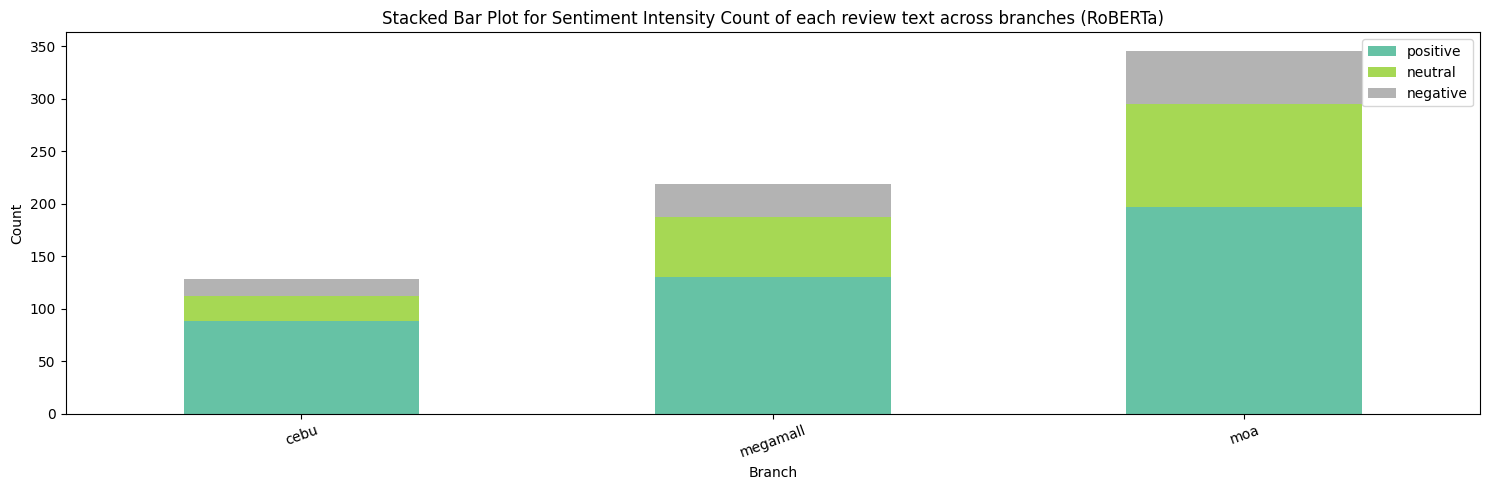

In [258]:
pos, neu, neg = [], [], []

for branch in sorted(data_roberta['branch'].unique()):
    for intensity in sorted(data_roberta['sentiment_int'].unique()):
        filt = (data_roberta['branch'] == branch) & (data_roberta['sentiment_int'] == intensity)
        if intensity == 'positive':
            pos.append(len(data_roberta[filt]))
        if intensity == 'neutral':
            neu.append(len(data_roberta[filt]))
        if intensity == 'negative':
            neg.append(len(data_roberta[filt]))

branch_sentimentint_df = pd.DataFrame({
    'positive' : pos,
    'neutral' : neu,
    'negative' : neg
}, index=sorted(data['branch'].unique()))

ax = branch_sentimentint_df.plot(
    kind='bar',
    stacked=True,
    figsize=(15, 5),
    colormap='Set2'
)

ax.set_title('Stacked Bar Plot for Sentiment Intensity Count of each review text across branches (RoBERTa)')
ax.set_xlabel('Branch')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

plt.tight_layout()
plt.show()

For all branches, most of reviews with texts are positive and some are neutral. Also, review with texts that are negative have the least value counts across branches.

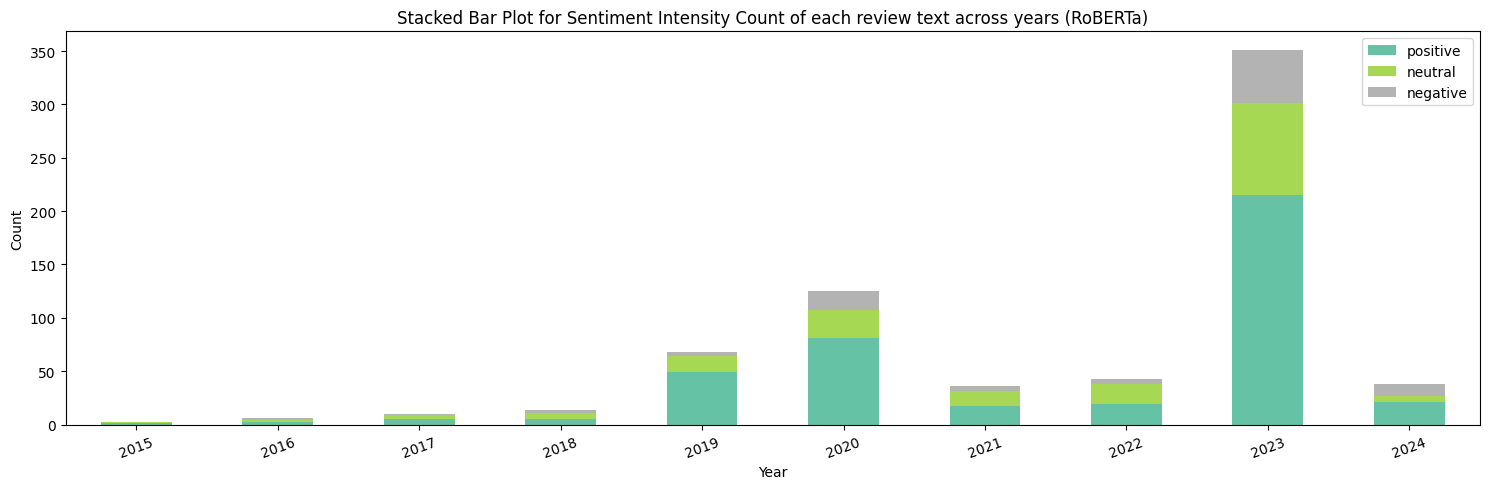

In [259]:
pos, neu, neg = [], [], []

for year in sorted(data_roberta['review_year'].unique()):
    for intensity in sorted(data_roberta['sentiment_int'].unique()):
        filt = (data_roberta['review_year'] == year) & (data_roberta['sentiment_int'] == intensity)
        if intensity == 'positive':
            pos.append(len(data_roberta[filt]))
        if intensity == 'neutral':
            neu.append(len(data_roberta[filt]))
        if intensity == 'negative':
            neg.append(len(data_roberta[filt]))

year_sentimentint_df = pd.DataFrame({
    'positive' : pos,
    'neutral' : neu,
    'negative' : neg
}, index=sorted(data['review_year'].unique()))

ax = year_sentimentint_df.plot(
    kind='bar',
    stacked=True,
    figsize=(15, 5),
    colormap='Set2'
)

ax.set_title('Stacked Bar Plot for Sentiment Intensity Count of each review text across years (RoBERTa)')
ax.set_xlabel('Year')
ax.set_ylabel('Count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=20)

plt.tight_layout()
plt.show()

* According to the output of RoBERTa model, review texts were also mostly positive across all years.
* Similarly from VADER, RoBERTa tagged a significant portion of review texts in year 2024.

_Note: The data was scraped on April 2024 so the findings found from the data only represents up until that period._

### Notes and Miscellaenous

#### Function to print long review texts

Alternatively, `pd.set_option('max_colwidth', None)` can be used to display review texts in full view and wrapped in the DataFrame column.

In [187]:
def print_long_text(text, max_width=100):
    # Use textwrap to wrap the text at the specified width
    wrapped_text = textwrap.fill(text, width=max_width)

    # Print each line of the wrapped text
    for line in wrapped_text.split('\n'):
        print(line)

#### Effects of duplicate characters, emojis/emoticons, and exclamation points

In [216]:
def display_vader_roberta_scores(review_text):
    print_long_text(review_text)

    vader_scores_dict = get_sentiment(review_text)
    print(f"\nVADER Scores: {vader_scores_dict}")

    roberta_scores_dict = get_sentiment_scores_roberta(review_text)
    print(f"RoBERTa Scores: {roberta_scores_dict}")

    print("="*100)

In [217]:
# Add more set of texts if necessary
sample_texts = [
    "i love this",
    "i love thisss",
    "i love this!",
    "😊❤️😊",
    "i hate this so much",
    "i hate this so muchhhh",
    "i hate this so much!",
    "😡😡😡"
]

for text in sample_texts:
    display_vader_roberta_scores(text)

i love this

VADER Scores: {'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}
RoBERTa Scores: {'neg': 0.0063491124, 'neu': 0.018766722, 'pos': 0.97488415}
i love thisss

VADER Scores: {'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'compound': 0.6369}
RoBERTa Scores: {'neg': 0.0036281133, 'neu': 0.012417711, 'pos': 0.9839542}
i love this!

VADER Scores: {'neg': 0.0, 'neu': 0.182, 'pos': 0.818, 'compound': 0.6696}
RoBERTa Scores: {'neg': 0.0032893482, 'neu': 0.010653037, 'pos': 0.9860576}
😊❤️😊

VADER Scores: {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
RoBERTa Scores: {'neg': 0.0020768628, 'neu': 0.041949254, 'pos': 0.9559739}
i hate this so much

VADER Scores: {'neg': 0.552, 'neu': 0.448, 'pos': 0.0, 'compound': -0.5719}
RoBERTa Scores: {'neg': 0.9782196, 'neu': 0.01767648, 'pos': 0.004103789}
i hate this so muchhhh

VADER Scores: {'neg': 0.552, 'neu': 0.448, 'pos': 0.0, 'compound': -0.5719}
RoBERTa Scores: {'neg': 0.98003757, 'neu': 0.016115552, 'pos': 0.0038468211}
i hate

Given some samples of texts with duplicated characters, emojis/emoticons, and exclamation marks, here are the following observations:
* For VADER, duplicated characters seem to provide no difference. However, there is a minimal difference when there is an exclamation mark. Moreover, emojis/emoticons completely have no influence on the scores and defaulting to neutral.

* For RoBERTa, the presence of duplicated characters and exclamation marks provide minimal difference. It also seems to recognize the sentiments behind emojis/emoticons.

### Conclusion and Recommendation

#### Conclusion

* Based on the analysis on the reviews scraped from the internet. It seems that I'm expecting a good time ice skating here in the Philippines with the reviews having an average rating of 4.311 out of 5.0.
* This is further supported by the sentiment intensity analysis output from VADER and RoBERTa wherein for all branches, most of the review texts sentiments were positive.
* Similar findings can be concluded from the output VADER and RoBERTa as the difference was minimal.
* With sentiments such as positive, negative, and neutral being subjective yet intuitive for almost everyone, the tags generated during the Sentiment Intensity Analysis might not be completely correct, even though the stacked barplots show the consistency behind the sentiment intensity tags and review ratings. This limitation is caused by the data not having a target sentiment intensity tag or class to compare with.

#### Recommendation
* As discussed earlier, duplicate characters, emojis, and exclamation marks intensify the sentiment behind a text. In contrast to the method of standardization of words during preprocessing, these elements can be kept prior the Sentiment Intensity Analysis.
* To narrow down the cause of negative reviews as these might be dealbreakers despite of the high review ratings, **topic modeling** can be performed. It is a technique used to discover latent topics that exists within a collection of documents. For instance, upon reviewing all review texts, I noticed the frequent apperance of these negative themes: issues with skating shoes and issues with personnels.